In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

from argparse import ArgumentParser
import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.datasets.datasets import ATLASDataset 
from torchlib.neuralnet import NeuralNetClassifier
from misc import get_transforms_det

from sklearn import metrics

In [2]:
pathname = os.path.expanduser( '~/.datasets' )
projectnet='../out/netruns'
no_cuda=False
seed=1
gpu=0
batch_size=60
workers=10
num_input_channels=3

print(pathname)
print(projectnet)

/home/fernandez/.datasets
../out/netruns


In [3]:
!ls ../out/netruns/

atlas_baseline_inception_v4_mix_adam_atlas_004
atlas_baseline_preactresnet18_bcewl_adam_atlas_001
atlas_baseline_preactresnet18_mix_sgd_atlas_002
atlas_baseline_preactresnet18_mix_sgd_atlas_003
results


In [5]:
name = 'atlas_baseline_inception_v4_mix_adam_atlas_004'
project = os.path.join(projectnet, name)
model = 'model_best.pth.tar' #'chk000025.pth.tar', model_best
pathmodels = os.path.join(project,'models',model)

print(project)
print(pathmodels)

../out/netruns/atlas_baseline_inception_v4_mix_adam_atlas_004
../out/netruns/atlas_baseline_inception_v4_mix_adam_atlas_004/models/model_best.pth.tar


## Load model

In [6]:
# neuralnet
network = NeuralNetClassifier(
    patchproject=project,
    nameproject=name,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu
    )

cudnn.benchmark = True

# load model
if network.load( pathmodels ) is not True:
    assert(False)

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


=> loading checkpoint '../out/netruns/atlas_baseline_inception_v4_mix_adam_atlas_004/models/model_best.pth.tar'
=> loaded checkpoint for inception_v4 arch!


In [7]:

pathdata='~/.kaggle/competitions/human-protein-atlas-image-classification'
name_dataset='atlas'
subset='train'

data = ATLASDataset(        
    path=pathdata, 
    train=True,
    folders_images='train', 
    metadata='train.csv',
    count=100,
    num_channels=3,
    transform=get_transforms_det( network.size_input ), #get_transforms_aug
    )

dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )

print('Data loader ')
print(len(dataloader))
print(len(data))

Data loader 
2
100


In [8]:
Id, Yhat, Y = network.predict( dataloader )
df = pd.DataFrame( np.concatenate((Id[:,np.newaxis], Yhat, Y), axis=1) )
df.to_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset,name,name_dataset)), index=False, encoding='utf-8')        
print('dir: {}'.format(project))
print('DONE!!!')

100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

dir: ../out/netruns/atlas_baseline_inception_v4_mix_adam_atlas_004
DONE!!!


In [9]:
df = pd.read_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset, name, name_dataset))  )
df.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,0.996777,0.000137,0.004408,0.000041,0.000043,0.033597,2.368870e-05,0.000072,6.277839e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,0.999955,0.999994,0.999656,0.048086,0.000008,0.000238,2.153798e-07,0.999743,3.785484e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,0.000514,0.000060,0.000119,0.000079,0.001248,0.998795,3.205983e-04,0.001201,7.573904e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,0.004212,0.999775,0.002247,0.000884,0.000055,0.000454,1.851627e-04,0.000822,4.154341e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,0.014452,0.000202,0.000373,0.000037,0.000140,0.000448,4.032355e-04,0.000012,9.856312e-06,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
(Yhat>0.4).sum(axis=0)

array([38,  6, 14,  6,  1,  6,  3,  8,  0,  0,  0,  4,  3,  2,  4,  0,  1,
        1,  4,  1,  1, 12,  2, 12,  1, 21,  0,  0])

In [12]:
Y.sum(axis=0)

array([38.,  6., 14.,  6.,  2.,  6.,  4.,  9.,  0.,  0.,  0.,  4.,  4.,
        2.,  4.,  0.,  3.,  1.,  4.,  1.,  1., 13.,  2., 11.,  1., 24.,
        0.,  0.])

In [31]:
Y

array([1.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0], dtype=object)

In [51]:

th=0.8
result = df.as_matrix()
iDs = result[:,0]
yhat = (result[:,1:28+1] > th ).reshape(-1).astype( np.int )
y =   result[:,28+1:].reshape(-1).astype( np.int )

acc = metrics.accuracy_score( y, yhat)
precision = metrics.precision_score(y, yhat, average='macro')
recall = metrics.recall_score(y, yhat, average='macro')
f1_score = 2*precision*recall/(precision+recall)

print('Accuracy : %f' % acc)
print('Precision : %f' % precision)
print('Recall : %f' % recall)
print('F1 score : %f' % f1_score)
print("")

Accuracy : 0.994286
Precision : 0.990604
Recall : 0.955871
F1 score : 0.972928



In [56]:

result = df.as_matrix()
iDs = result[:,0]
ths=[ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  ]
F1s = []

for th in ths:
    yhat = (result[:,1:28+1] > th ).reshape(-1).astype( np.int )
    y =   result[:,28+1:].reshape(-1).astype( np.int )
    acc = metrics.accuracy_score( y, yhat)
    precision = metrics.precision_score(y, yhat, average='macro')
    recall = metrics.recall_score(y, yhat, average='macro')
    f1_score = 2*precision*recall/(precision+recall)
    F1s.append( f1_score )
    print(th, f1_score)

    

0.1 0.9783956987463799
0.2 0.9766730171366362
0.3 0.978204339277714
0.4 0.9746948989560736
0.5 0.9746948989560736
0.6 0.9729648003727778
0.7 0.9746564738559198
0.8 0.9729275889566997
0.9 0.971193998551773


In [52]:
metric = metrics.classification_report(y, yhat)
print(metric)

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      2640
          1       0.99      0.91      0.95       160

avg / total       0.99      0.99      0.99      2800



In [53]:
mc = metrics.confusion_matrix(y, yhat)
print(mc)

[[2638    2]
 [  14  146]]


Normalized confusion matrix


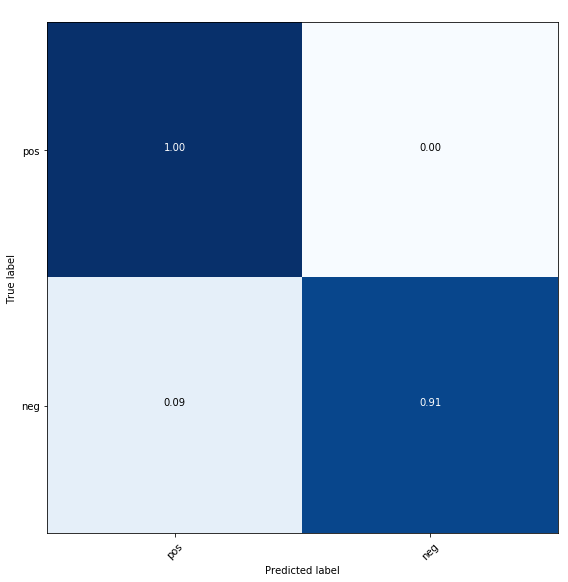

In [55]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure( figsize=(8,8))
plot_confusion_matrix(mc, classes=['pos','neg'], title=' ')
plt.show()